Focus: 
> The titanic data set

Question:
> What was the difference in survival between passengers of different ticket classes?

Selection of variables:

variable | description | comment
 :--- | :--- | :---
survived | Survived? | 0 = No, 1 = Yes 
pclass | Ticket Class | 1 = 1<sup>st</sup>, 2 = 2<sup>nd</sup>, 3 = 3<sup>rd</sup>
sex | Sex |  
age | Age: years|  
sibsp | Siblings & Spouses | \# of siblings and/or spouses aboard
parch | Parents & Children | \# of parents and/or children aboard
fare | Passenger Fare |        
embarked &nbsp; | Port of Embarkation |  C = Cherbourg, Q = Queenstown, S = Southampton
alone | Travelling alone? |  

<br>

## Preliminaries

### Packages

In [1]:
import subprocess

In [2]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/miscellane/review/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

### Paths

In [3]:
import os
import pathlib
import sys

In [4]:
if not 'google.colab' in str(get_ipython()):
    
    notebooks = os.getcwd()
    parent = str(pathlib.Path(notebooks).parent)
    sys.path.append(parent)
    sys.path.append(os.path.join(parent, 'review'))

<br>

### Libraries

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections

import pandas as pd
import scipy.stats

<br>

**Custom**

In [6]:
import review.graphics.settings
import review.algorithms.disaggregate

<br>

Graphs

In [7]:
settings = review.graphics.settings.Settings()

settings.aesthetics()
settings.layout()

<br>

For disaggregates

In [8]:
Features = collections.namedtuple(typename='Features', field_names=['fields', 'index', 'columns', 'level'])

<br>
<br>

## Data

Reading-in a few fields of interest

In [9]:
url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv'

dtype = {'survived': int, 'pclass': 'category', 'sex': 'category', 'age': float, 'sibsp': 'category', 
         'parch': 'category', 'fare': float, 'embarked': 'category', 'who': 'category', 'alone': bool}

data = pd.read_csv(filepath_or_buffer=url, header=0, encoding='utf-8', usecols=list(dtype.keys()), dtype=dtype)
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,alone
0,0,3,male,22.0,1,0,7.2500,S,man,False
1,1,1,female,38.0,1,0,71.2833,C,woman,False
2,1,3,female,26.0,0,0,7.9250,S,woman,True
3,1,1,female,35.0,1,0,53.1000,S,woman,False
4,0,3,male,35.0,0,0,8.0500,S,man,True


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   survived  891 non-null    int32   
 1   pclass    891 non-null    category
 2   sex       891 non-null    category
 3   age       714 non-null    float64 
 4   sibsp     891 non-null    category
 5   parch     891 non-null    category
 6   fare      891 non-null    float64 
 7   embarked  889 non-null    category
 8   who       891 non-null    category
 9   alone     891 non-null    bool    
dtypes: bool(1), category(6), float64(2), int32(1)
memory usage: 24.8 KB


<br>
<br>

## Exploratory Analysis

### Survival Rates by Passenger Class

In [11]:
disaggregate = review.algorithms.disaggregate.Disaggregate(data=data, features=Features._make((['survived', 'pclass'], 'survived', 'pclass', None)))
frequencies, totals, rates, decomposition = disaggregate.exc()

<br>

**\# of survivors by passenger class**

In [12]:
frequencies

pclass,1,2,3
survived,,,
0,80,97,372
1,136,87,119


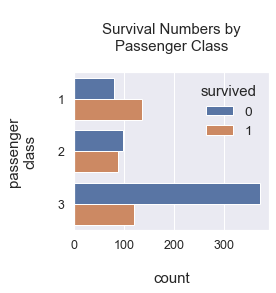

In [13]:
plt.figure(figsize=(3.5, 2.9));
plt.tick_params(axis='both', labelsize='small')

graph = sns.countplot(data=data, y='pclass', hue='survived')
plt.title('\nSurvival Numbers by\nPassenger Class\n');
plt.ylabel('passenger\nclass\n');
plt.xlabel('\ncount');

In [14]:
graph.get_figure().savefig(
    'titanic/by_class.png', pad_inches=0.25, transparent=True,
    bbox_inches=matplotlib.transforms.Bbox([[-0.5, -0.5], [3.5, 3.5]]))

<br>

**\# of passengers per class**

In [15]:
totals

pclass
1    216
2    184
3    491
dtype: int64

<br>

**Survival rates by passenger class**

In [16]:
rates

pclass,1,2,3
survived,,,
0,0.37037,0.527174,0.757637
1,0.62963,0.472826,0.242363


<br>

**Illustrations**

* $decomposition = melt(rates)$

In [17]:
decomposition.head()

,survived,pclass,rate
0,0,1,0.370370
1,1,1,0.629630
2,0,2,0.527174
3,1,2,0.472826
4,0,3,0.757637


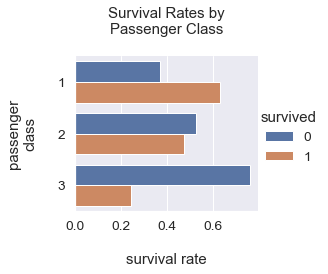

In [18]:
ax = sns.catplot(x='rate', y='pclass', hue='survived', data=decomposition, kind='bar', height=2.9, aspect=1.1, legend_out=True);
ax.set_axis_labels('\nsurvival rate','passenger\nclass\n').set(title='Survival Rates by\nPassenger Class\n');

In [19]:
ax.savefig('titanic/by_class_rates.png', pad_inches=0.25, transparent=True, 
           bbox_inches=matplotlib.transforms.Bbox([[-0.5, -0.5], [3.5, 3.5]]))

<br>

### Statistical Analysis

This section is focused on the question

> Is there a statistically significant dependence between survival & passenger class? 

This is explored via the $\chi^{2}$ Squared Test of Independence [(test data assumptions)](https://www.statology.org/chi-square-test-assumptions/), whereby the hypothesis is

> H<sub>0</sub>: survival &perp; passenger class<br>
> H<sub>1</sub>: otherwise

An additional measure is Cram$\acute{e}$r's $V$, which measures the degree of association between a pair of variables.

<br>

**$\chi^{2}$ Test of Independence**

In [20]:
statistic, p_value, degrees_of_freedom, expected = scipy.stats.chi2_contingency(observed=frequencies)
p_value

4.549251711298793e-23

<br>

**Cram$\acute{e}$r's $V$**

[Later: Is the scipy [Cram$\acute{e}$r's $V$](https://docs.scipy.org/doc/scipy-1.7.1/reference/generated/scipy.stats.contingency.association.html) algorithm [bias corrected](https://en.wikipedia.org/wiki/Cramér%27s_V#Bias_correction)?]

In [21]:
# scipy.stats.contingency.association(observed=frequencies, method='cramer', correction=False)

<br>
<br>

## Discussion

Approximately 63.0% of first class passengers survived, whereas 47.3% & 24.2% of second & third class passengers, respectively, survived.  This led to the 
question, is there a statistically significant dependence between survival & passenger class?  The $\chi^{2}$ Test $p_{value}$ suggests that the null 
hypothesis of independence should be rejected.

The aforementioned contemporaneous investigations indicated that the evacuation policy prioritised class, and then females & children.  The policy probably 
explains why the survival rate declines with class, and why the statistical measures suggest a dependency between survival rate & passenger class.  However, 
further disaggregation by children/woman/man (addendum) does not illustrate a neat association between survival rate & evacuation policy steps, i.e.,

> passenger class $\longrightarrow$ females & children $\longrightarrow$ males

Other confounding factors might account for this unclear pattern.  For example, the investigations also suggested that survival rates might have been 
a affected by passenger lodging location (unfortunately the dataset does not include lodging location).  What combination of variables dictates a passenger's
lodging location?  For a number of passengers … especially females & children, and domestic aides of the time … this might additionally depend on the fare payer, 
and prevailing rules & customs.

A detailed analysis will shed more light in unanswered questions.

**Limitations:**
> A few fields have missing values.

**Assumptions:**
> Independent dataset instances, i.e., the value of an observation in the dataset does not affect the value of another observation.


<br>
<br>

### Addendum

```python
ax = sns.catplot(y='pclass', hue='survived', data=data, col='who', kind='count', height=2.9, aspect=1.05, legend_out=False);
ax.set_axis_labels('count','passenger\nclass\n').set_titles('{col_name}');
```

In [22]:
disaggregate = review.algorithms.disaggregate.Disaggregate(
    data=data, features=Features._make((['who', 'survived', 'pclass'], ['who', 'survived'], 'pclass', 'who')))
frequencies, totals, rates, decomposition = disaggregate.exc()

<br>

**Frequencies**

In [23]:
frequencies

pclass             1     2      3
who   survived                   
child 0          1.0   NaN   33.0
      1          5.0  19.0   25.0
man   0         77.0  91.0  281.0
      1         42.0   8.0   38.0
woman 0          2.0   6.0   58.0
      1         89.0  60.0   56.0

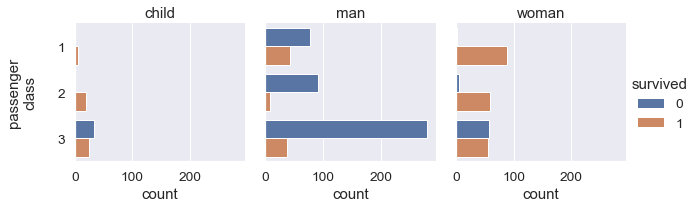

In [24]:
ax = sns.catplot(y='pclass', hue='survived', data=data, col='who', kind='count', height=2.9, aspect=0.95, legend_out=True);
ax.set_axis_labels('count','passenger\nclass\n').set_titles('{col_name}');

In [25]:
ax.savefig('titanic/by_desc_class.png', pad_inches=0.25, 
           bbox_inches=matplotlib.transforms.Bbox([[-0.5, -0.5], [9.5, 3.1]]))

<br>

**Rates**

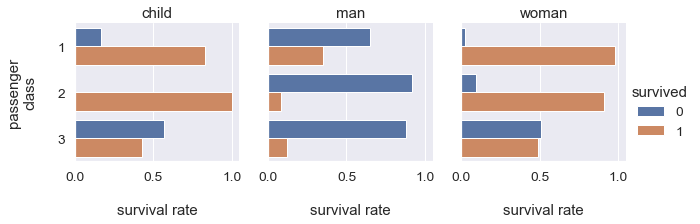

In [26]:
ax = sns.catplot(x='rate', y='pclass', hue='survived', data=decomposition, col='who', kind='bar', height=2.9, aspect=0.95, legend_out=True);
ax.set_axis_labels('\nsurvival rate','passenger\nclass\n').set_titles('{col_name}');

In [27]:
ax.savefig('titanic/by_desc_class_rates.png', pad_inches=0.25, 
           bbox_inches=matplotlib.transforms.Bbox([[-0.5, -0.5], [9.5, 3.1]]))